In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np
import torch
from PIL import Image, ImageOps
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from random import randrange
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
bilinear = False

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=9)
        # self.conv2 = nn.Conv2d(64,32, kernel_size=1)
        # self.conv3 = nn.Conv2d(32,3,kernel_size=5)
        self.conv1 = nn.Conv2d(1, 64, 9, 1, 4)
        self.conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 1, 5, 1, 2)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.conv3(x)
      return x

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(ConvBlock, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        block = []

        block.append(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1))
        block.append(nn.BatchNorm2d(mid_channels))
        block.append(nn.ReLU(inplace=True))

        block.append(nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1))
        block.append(nn.BatchNorm2d(out_channels))
        block.append(nn.ReLU(inplace=True))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.MaxPool2d(2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.down(x)
        return self.conv(x)

In [ ]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2, align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # padding
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
        block.append(nn.BatchNorm2d(channels))
        block.append(nn.ReLU(inplace=True))

        block.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
        block.append(nn.BatchNorm2d(channels))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        out += x
        return out

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.down = nn.MaxPool2d(2)
        self.conv = nn.Sequential(
            ResBlock(in_channels),
            ResBlock(in_channels),
            ResBlock(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            ResBlock(out_channels)
        )

    def forward(self, x):
        x = self.down(x)
        return self.conv(x)

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()

        self.up = nn.PixelShuffle(2)
        self.conv = ResBlock(out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # padding
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class Res_UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Res_UNet, self).__init__()
        
        self.first = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.down1 = DownBlock(32, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)
        self.up1 = UpBlock(512, 384)
        self.up2 = UpBlock(384, 224)
        self.up3 = UpBlock(224, 120)
        self.up4 = UpBlock(120, 62)
        self.last = nn.Conv2d(62, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.first(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.up1(x5, x4)
        out = self.up2(out, x3)
        out = self.up3(out, x2)
        out = self.up4(out, x1)
        out = self.last(out)
        return out

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.first = ConvBlock(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)
        self.last = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.first(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.up1(x5, x4)
        out = self.up2(out, x3)
        out = self.up3(out, x2)
        out = self.up4(out, x1)
        out = self.last(out)
        return out

In [ ]:
def super_resolution(model, rgb_image, device):
  source_image = rgb_image.convert('YCbCr')
  y, cb, cr = source_image.split()
  transforms = transform.ToTensor()
  input = transforms(y).unsqueeze(0)
  prediction = model(input.to(device))
  target_y = (prediction[0].cpu().detach().numpy() * 255).clip(0, 255)
  target_y = Image.fromarray(np.asarray(target_y[0], dtype="uint8"))
  target_image = Image.merge('YCbCr', [target_y, cb, cr]) 
  return target_image.convert('RGB')

In [ ]:
def interpolation(scale, img):
  h, w, _ = img.shape
  img = cv2.resize(img,(0,0), fx=scale, fy=scale,interpolation = cv2.INTER_CUBIC)
  img = cv2.resize(img,(w,h),interpolation = cv2.INTER_CUBIC)
  return img

In [ ]:
def display(HR_image_path, model_name, scale, write_folder):
  if model_name == 'res_unet':
    model = Res_UNet(1,1).to('cuda')
    model.load_state_dict(torch.load("/content/drive/My Drive/CVProject/best_models/checkpoint_2_51_RUNet.pth"))
  elif model_name == 'unet':
    model = UNet(1, 1).to('cuda')
    model.load_state_dict(torch.load("/content/drive/My Drive/CVProject/best_models/checkpoint_4_98_UNet.pth"))
  else:
    model = SRCNN().to('cuda')
    model.load_state_dict(torch.load("/content/drive/My Drive/CVProject/best_models/checkpoint_4_199_SRCNN.pth"))
  HR_image = cv2.imread(HR_image_path)
  cv2_imshow(HR_image)
  cv2.imwrite(write_folder + "/HR.png", HR_image)
  LR_image = interpolation(scale, HR_image)
  cv2_imshow(LR_image)
  cv2.imwrite(write_folder + "/LR.png", LR_image)
  pil_LR_image = Image.fromarray(cv2.cvtColor(LR_image, cv2.COLOR_BGR2RGB))
  prediction_image = super_resolution(model, pil_LR_image, 'cuda')
  prediction_image.save(write_folder + "/prediction.png")
  return prediction_image

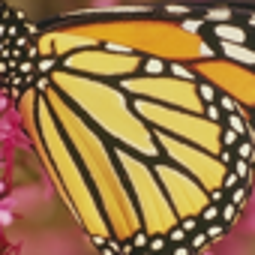

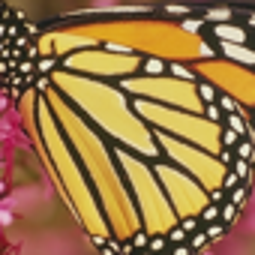

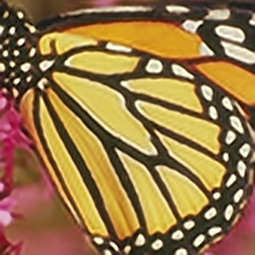

In [ ]:
prediction_image = display("/content/drive/My Drive/test.bmp", 'srcnn', 4, "/content/drive/My Drive/SRCNN")
prediction_image

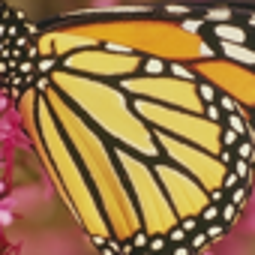

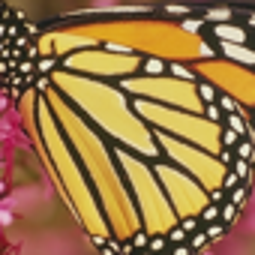

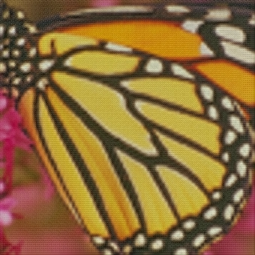

In [ ]:
display("/content/drive/My Drive/test.bmp", 'res_unet', 4, "/content/drive/My Drive/RUNET")

In [1]:
display("/content/drive/My Drive/test.bmp", 'unet', 4, "/content/drive/My Drive/UNET")

'/content/drive/My Drive/test.bmp'

'unet'

4

'/content/drive/My Drive/UNET'